In [1]:
import numpy as np
import scipy.stats
import json
import random
import prior_envs, diffplan, envs, search, spectral

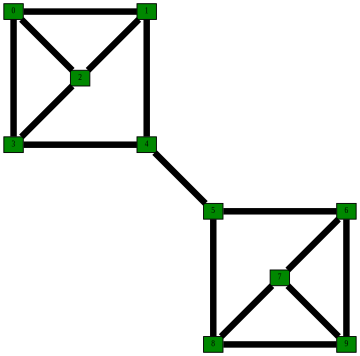

In [2]:
env = prior_envs.f2c
diffplan.plot_graph(env, size=5, labels=list(map(str, range(len(env.states)))))

In [3]:
tasks = [
    dict(start=s, goal=g, optimal=search.bfs(env, s, g)['cost'])
    for s in env.states
    for g in env.states
    if s != g
]
import collections
print('counts for path lengths', sorted(collections.Counter(t['optimal'] for t in tasks).items()))
print(len(tasks))

# Filter out length-1 tasks
tasks = [t for t in tasks if t['optimal'] != 1]
print(len(tasks))

counts for path lengths [(1, 30), (2, 20), (3, 16), (4, 16), (5, 8)]
90
60


In [4]:
# Write out graph
graph = [
    [s, [env.step(s, a)[0].item() for a in env.actions]]
    for s in env.states
]

# Write out state orders
np.random.seed(27430)
state_orders = [so.tolist() for so in [
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
]]
for so in state_orders:
    print
state_orders.pop(3) # This is a bad ordering.
state_orders.pop(1) # This is a bad ordering.
print(state_orders)

# Write out task orders
random.seed(27432)
def shuffled(l):
    l = list(l) # we make a copy here...
    random.shuffle(l) # because this is in-place!
    return l
task_orders = []
for _ in range(8):
    task_orders.append(shuffled(tasks))

# Write out probes
random.seed(27432)
simple_probes = shuffled([
    dict(start=p[0], goal=p[1])
    for s, g in [(1, 3), (6, 8)]
    for p in [[s, g], [g, s]]
])
hard_probes = shuffled([
    dict(start=p[0], goal=p[1])
    for s in [1, 3]
    for g in [6, 8]
    for p in [[s, g], [g, s]]
])
print('simple_probes', simple_probes)
print('hard_probes', hard_probes)

[[1, 5, 8, 6, 7, 4, 0, 9, 2, 3], [6, 1, 8, 0, 5, 3, 2, 7, 4, 9], [6, 8, 7, 2, 4, 9, 5, 1, 3, 0], [9, 6, 1, 4, 0, 2, 8, 5, 3, 7]]
simple_probes [{'start': 3, 'goal': 1}, {'start': 6, 'goal': 8}, {'start': 1, 'goal': 3}, {'start': 8, 'goal': 6}]
hard_probes [{'start': 3, 'goal': 6}, {'start': 8, 'goal': 3}, {'start': 1, 'goal': 8}, {'start': 1, 'goal': 6}, {'start': 3, 'goal': 8}, {'start': 8, 'goal': 1}, {'start': 6, 'goal': 1}, {'start': 6, 'goal': 3}]


In [42]:
def write_json_module(fn, data):
    with open(fn, 'w') as f:
        f.write('export default ')
        #json.dump(data, f, indent=2)
        json.dump(data, f)
        f.write(';')

write_json_module('experiment/trials.js', dict(
    graph=graph,
    stateOrders=state_orders,
    taskOrders=task_orders,
    simpleProbes=simple_probes,
    hardProbes=hard_probes,
))


In [43]:
# Making sure pre-pilot has enough...
pre_pilot_limit = 15
for idx, to in enumerate(task_orders):
    print(idx, 'counts for pre-pilot', sorted(collections.Counter(t['optimal'] for t in to[:pre_pilot_limit]).items()))

write_json_module('experiment/pre_pilot_trials.js', dict(
    graph=graph,
    stateOrders=[state_orders[0], state_orders[1]],
    taskOrders=[task_orders[2], task_orders[7]], # Picked these since they seem most balanced among difficulties
    simpleProbes=simple_probes,
    hardProbes=hard_probes,
))

0 counts for pre-pilot [(2, 3), (3, 4), (4, 6), (5, 2)]
1 counts for pre-pilot [(2, 8), (3, 2), (4, 3), (5, 2)]
2 counts for pre-pilot [(2, 5), (3, 4), (4, 4), (5, 2)]
3 counts for pre-pilot [(2, 3), (3, 4), (4, 4), (5, 4)]
4 counts for pre-pilot [(2, 5), (3, 7), (4, 2), (5, 1)]
5 counts for pre-pilot [(2, 4), (3, 7), (4, 3), (5, 1)]
6 counts for pre-pilot [(2, 9), (3, 3), (4, 3)]
7 counts for pre-pilot [(2, 5), (3, 5), (4, 3), (5, 2)]


In [44]:
!mkdir -p ~/pu/cocosci-optdisco/static/optdisco/js/configuration/
!ls -lah experiment/*.js
!cp experiment/*.js ~/pu/cocosci-optdisco/static/optdisco/js/configuration/

-rw-r--r--  1 carlos  staff   5.2K May 28 01:35 experiment/pre_pilot_trials.js
-rw-r--r--  1 carlos  staff    19K May 28 01:35 experiment/trials.js


# Analyzing stimuli
Some graph orderings seem especially easy, or like they have strong clustering. Comparing two metrics below: number of edges that are along the perimeter (or: how many neighbors on the circle are true neighbors in the graph) and spearman rank correlation to the best 1-dimensional embedding.

In [9]:
fiedler_order = spectral.fiedler(env).argsort()

np.random.seed(27430)
state_orders = [so.tolist() for so in [
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
    np.random.permutation(len(env.states)),
]]

def edges_on_side(so, max_distance_penalty=2):
    total = 0
    for idx, s in enumerate(so):
        circle_neighbors = lambda dist: {
            so[(idx - dist) % len(so)],
            so[(idx + dist) % len(so)],
        }
        neighbors = {env.step(s, a)[0].item() for a in env.actions}
        p = 1/2
        total += sum(
            p**dist * len(circle_neighbors(dist+1) & neighbors)
            for dist in range(max_distance_penalty)
        ) ** 2
    return total/2 # remove symmetry

for so in state_orders:
    print(so)
    so_rots = [so[idx:] + so[:idx] for idx in range(len(so))]
    so_rot = max(so_rots, key=lambda so_rot: abs(scipy.stats.spearmanr(so_rot, fiedler_order).correlation))
    print(scipy.stats.spearmanr(so_rot, fiedler_order))
    print('# edges on side (d=1)', edges_on_side(so, max_distance_penalty=1))
    print('# edges on side (d=2)', edges_on_side(so, max_distance_penalty=2))
    print('# edges on side (d=3)', edges_on_side(so, max_distance_penalty=3))
    print()

[1, 0, 6, 4, 3, 7, 8, 2, 9, 5]
SpearmanrResult(correlation=-0.7939393939393938, pvalue=0.0060999233136969115)
# edges on side (d=1) 3.0
# edges on side (d=2) 3.75
# edges on side (d=3) 7.125

[8, 7, 5, 6, 2, 0, 1, 9, 3, 4]
SpearmanrResult(correlation=-0.5393939393939393, pvalue=0.1075931877824148)
# edges on side (d=1) 6.0
# edges on side (d=2) 9.75
# edges on side (d=3) 12.4375

[7, 8, 6, 0, 5, 2, 9, 4, 3, 1]
SpearmanrResult(correlation=0.3939393939393939, pvalue=0.25999776683488757)
# edges on side (d=1) 2.0
# edges on side (d=2) 4.25
# edges on side (d=3) 5.75

[1, 9, 4, 8, 7, 5, 6, 0, 3, 2]
SpearmanrResult(correlation=-0.6848484848484848, pvalue=0.02888279750673276)
# edges on side (d=1) 7.0
# edges on side (d=2) 13.0
# edges on side (d=3) 14.9375

[3, 6, 2, 9, 8, 0, 5, 4, 7, 1]
SpearmanrResult(correlation=-0.5151515151515151, pvalue=0.12755286970323426)
# edges on side (d=1) 2.0
# edges on side (d=2) 5.0
# edges on side (d=3) 6.3125



In [11]:
# making sure tasks are well-distributed among difficulties

limit = 30

random.seed(27432)
for _ in range(8):
    t = shuffled(tasks)
    print(collections.Counter(task['optimal'] for task in t[:limit]))


Counter({4: 12, 3: 6, 2: 6, 5: 6})
Counter({2: 11, 4: 8, 3: 7, 5: 4})
Counter({2: 11, 4: 8, 3: 7, 5: 4})
Counter({2: 9, 4: 8, 3: 7, 5: 6})
Counter({2: 10, 3: 9, 4: 8, 5: 3})
Counter({3: 11, 2: 9, 4: 8, 5: 2})
Counter({2: 14, 4: 8, 3: 6, 5: 2})
Counter({2: 12, 4: 8, 3: 7, 5: 3})
